In [253]:
import pandas as pd
import numpy as np
import math

In [254]:
tr_df = pd.read_csv('traffic.csv')[:230]

In [255]:
tr_df.head()

,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0


In [256]:
def compensator(t_k, alp, bta, lam, Ti):
  ctk = lam*t_k
  for i in range(len(Ti)):
    ctk += (alp/bta)*(np.exp(bta*(t_k-Ti[i]))-1)
  return ctk

In [257]:
len(tr_df)

230

In [258]:
tr_df.iloc[-1]

,229
Date,8/17/2020
Visits,3456.0


In [259]:
Cv = np.cumsum(np.array(tr_df['Visits']))

In [260]:
tr_df['CVis'] = Cv

In [261]:
tr_df.head()

,Date,Visits,CVis
0,01-01-2020,1554.0,1554.0
1,01-02-2020,2820.0,4374.0
2,01-03-2020,2970.0,7344.0
3,01-04-2020,2111.0,9455.0
4,01-05-2020,2393.0,11848.0


In [262]:
True in list(tr_df['Visits'][:229].isna())

False

<Axes: >

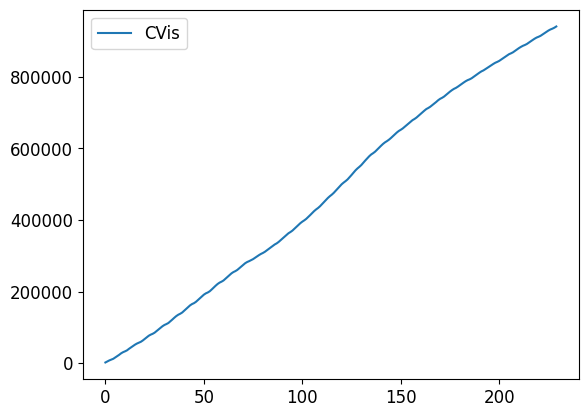

In [263]:
tr_df[['CVis']].plot(kind='line')

In [264]:
tr_df['P'] = tr_df['CVis']/3500.0
tr_df['H'] = np.array([math.floor(i) for i in list(tr_df['P'])])

In [265]:
t = []
ev = list(tr_df['H'][:30])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

In [15]:
#!pip install hawkeslib

In [16]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP

In [266]:


uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

(0.8650223819589516, 0.6416864863029725, 0.018881820073914406)


In [19]:
#!pip install hawkes

In [20]:
import Hawkes as hk

In [267]:
model = hk.simulator()

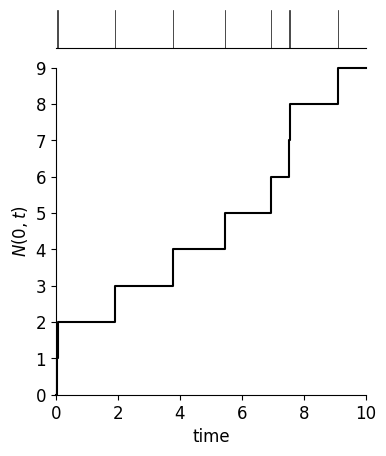

In [268]:
para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
model.plot_N()
#model.plot_l()

In [269]:
tr_dfp = tr_df[30:40]

In [270]:
len(tr_dfp)

10

In [271]:
T

array([0.02381163, 0.08036461, 1.89564646, 3.76775759, 5.46698678,
       6.93932315, 7.51816007, 7.54376413, 9.09872619])

In [272]:
len(T)

9

In [273]:
M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

34768.0 34911.8


In [274]:
Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

In [275]:
pd.DataFrame(Ts).describe()

,0
count,10000.000000
mean,32203.850000
std,11108.443182
min,0.000000
25%,24500.000000
50%,31500.000000
75%,38500.000000
max,77000.000000


In [276]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
len(preds.query('31230 < p < 38170'))/10000

0.2375

<Axes: ylabel='Frequency'>

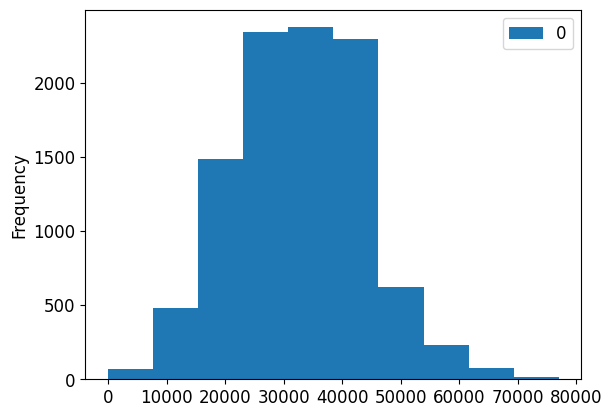

In [277]:
pd.DataFrame(Ts).plot(kind='hist')

In [278]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [279]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][:30]).fit()
forecast_ses = model_ses.forecast(10)

In [280]:
forecast_ses

,0
30,4486.0
31,4486.0
32,4486.0
33,4486.0
34,4486.0
35,4486.0
36,4486.0
37,4486.0
38,4486.0
39,4486.0


In [281]:
from sklearn.linear_model import LinearRegression

In [282]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][:30])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))

In [283]:
lr_pred

[103320.73563218387,
 106801.69492028176,
 110282.65420837965,
 113763.61349647754,
 117244.57278457543,
 120725.53207267332,
 124206.49136077121,
 127687.4506488691,
 131168.40993696696,
 134649.36922506485]

In [284]:
lr_pred[-1]/M[-1]

0.9532023872650774

In [285]:
ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)

In [286]:
(ses_pd['CVis'].loc[39] - ses_pd['CVis'].loc[30])/(M[-1] - M[0])

1.1612402208349155

In [287]:
np.array(Ts).mean()/(M[-1] - M[0])

0.9262497123791992

<Axes: >

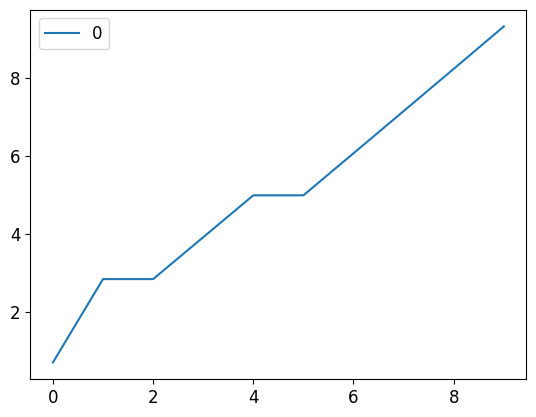

In [340]:
t = []
ev = list(tr_df['H'][30:40])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, t) for i in t]
pd.DataFrame(C).plot(kind='line')

In [341]:
tr_df.describe()

,Visits,CVis,P,H
count,230.000000,230.000000,230.000000,230.000000
mean,4092.382609,475934.465217,135.981276,135.469565
std,1013.848340,290111.232676,82.888924,82.860363
min,1554.000000,1554.000000,0.444000,0.000000
25%,3433.500000,222056.500000,63.444714,63.250000
50%,4000.500000,468817.500000,133.947857,133.500000
75%,4880.250000,744353.750000,212.672500,211.750000
max,6659.000000,941248.000000,268.928000,268.000000


In [342]:
tr_dfp

,Date,Visits,CVis,P,H
210,7/29/2020,3903.0,880700.0,251.628571,251
211,7/30/2020,3397.0,884097.0,252.599143,252
212,7/31/2020,3005.0,887102.0,253.457714,253
213,08-01-2020,2305.0,889407.0,254.116286,254
214,08-02-2020,2696.0,892103.0,254.886571,254
215,08-03-2020,3866.0,895969.0,255.991143,255
216,08-04-2020,3826.0,899795.0,257.084286,257
217,08-05-2020,3673.0,903468.0,258.133714,258
218,08-06-2020,3660.0,907128.0,259.179429,259
219,08-07-2020,3136.0,910264.0,260.075429,260


In [343]:
t = []
ev = list(tr_df['H'][30:60])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[60:70]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(1.1868156450303808, 0.03437276281434824, 0.05506729914989619)
39066.0 42019.6


In [344]:
np.array(Ts).mean()/(M[-1] - M[0])

1.0756053857574361

In [345]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('35100 < p < 42900'))/10000)

0.2191


<Axes: ylabel='Frequency'>

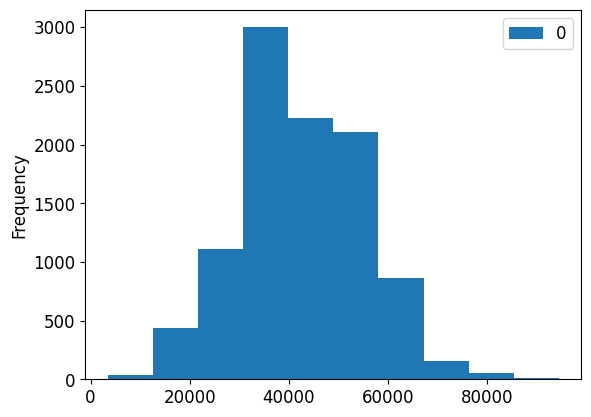

In [346]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

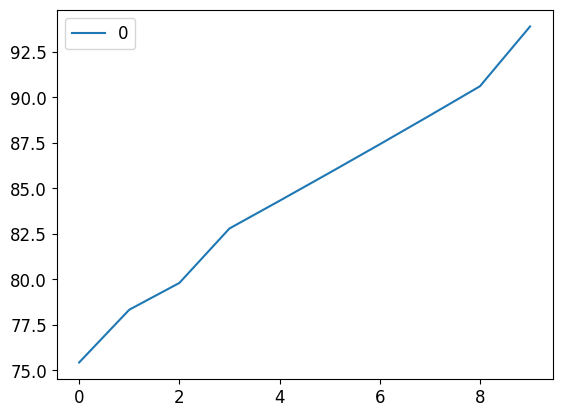

In [347]:
t = []
ev = list(tr_df['H'][60:70])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [348]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][30:60]).fit()
forecast_ses = model_ses.forecast(10)

In [349]:
ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[69] - ses_pd['CVis'].loc[60])/(M[-1] - M[0])

0.6191825616698399

In [350]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][30:60])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))

In [351]:
lr_pred[-1]/M[-1]

1.0027192672285832

In [352]:
t = []
ev = list(tr_df['H'][60:90])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[90:100]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(1.1360179057851163, 0.004741671626272035, 0.031607796056935325)
42553.0 39790.1


In [353]:
np.array(Ts).mean()/(M[-1] - M[0])

0.9350715578220101

In [354]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('38300 < p < 46700'))/10000)

0.3352


<Axes: ylabel='Frequency'>

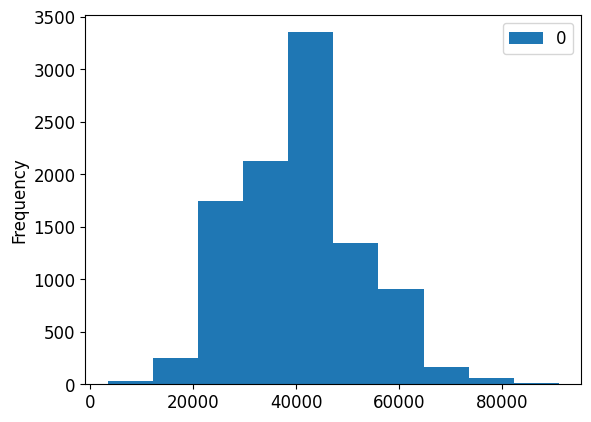

In [355]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

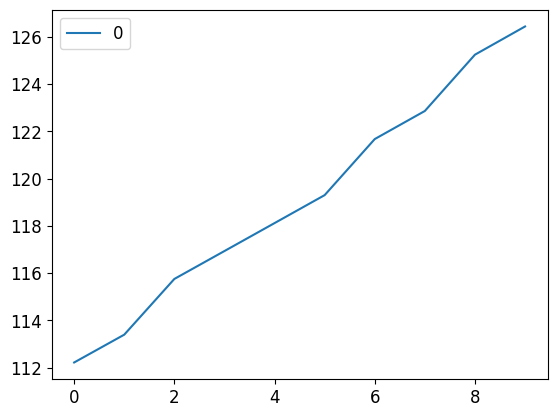

In [356]:
t = []
ev = list(tr_df['H'][90:100])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [357]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][60:90]).fit()
forecast_ses = model_ses.forecast(10)

ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[99] - ses_pd['CVis'].loc[90])/(M[-1] - M[0])

1.0352705619365463

In [358]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][60:90])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))
lr_pred[-1]/M[-1]

0.9716386865736031

In [359]:
t = []
ev = list(tr_df['H'][90:120])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[120:130]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(1.2339544610945963, 0.6772056180393581, 0.019531044304605963)
48732.0 46177.25


In [360]:
np.array(Ts).mean()/(M[-1] - M[0])

0.9475755150619716

In [361]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('43900 < p < 53500'))/10000)

0.279


<Axes: ylabel='Frequency'>

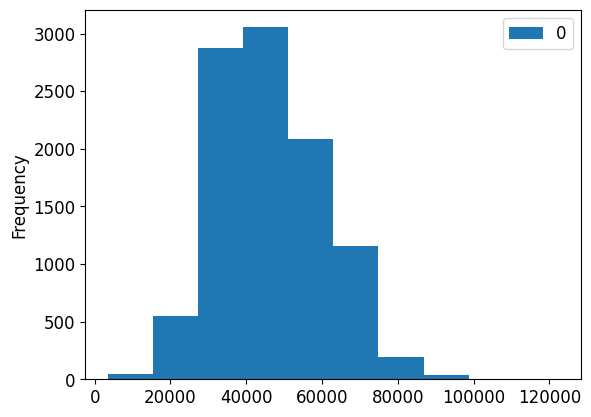

In [362]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

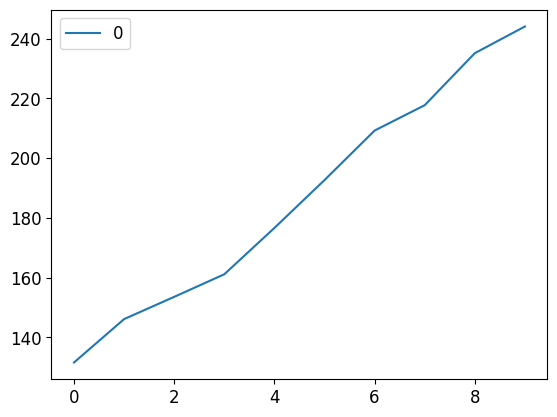

In [363]:
t = []
ev = list(tr_df['H'][120:130])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [364]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][90:120]).fit()
forecast_ses = model_ses.forecast(10)

ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[129] - ses_pd['CVis'].loc[120])/(M[-1] - M[0])

1.119792427455223

In [365]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][90:120])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))
lr_pred[-1]/M[-1]

0.9849771699654414

In [366]:
t = []
ev = list(tr_df['H'][120:150])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[150:160]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(1.4791383208609892, 0.004833367789075944, 0.053710937501129444)
39069.0 51754.85


In [367]:
np.array(Ts).mean()/(M[-1] - M[0])

1.3247037292994446

In [368]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('35100 < p < 42900'))/10000)

0.158


<Axes: ylabel='Frequency'>

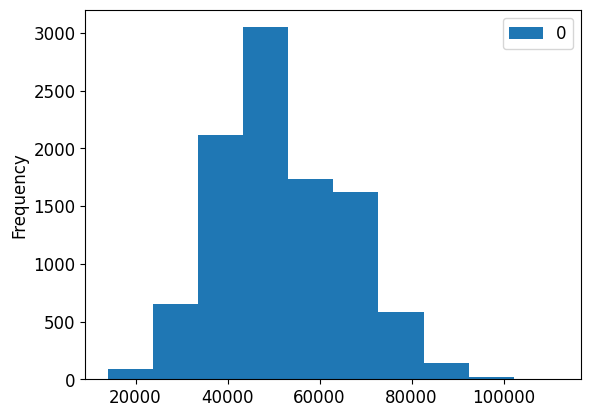

In [369]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

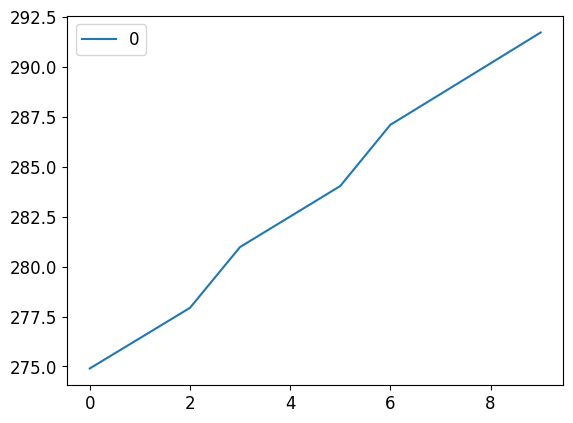

In [370]:
t = []
ev = list(tr_df['H'][150:160])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [371]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][120:150]).fit()
forecast_ses = model_ses.forecast(10)

ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[159] - ses_pd['CVis'].loc[150])/(M[-1] - M[0])

1.0112341793094213

In [372]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][120:150])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))
lr_pred[-1]/M[-1]

1.0190370646744

In [373]:
t = []
ev = list(tr_df['H'][150:180])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[180:190]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(1.1693773992119327, 0.005575026280150131, 0.046421695203067576)
31405.0 40737.2


In [374]:
np.array(Ts).mean()/(M[-1] - M[0])

1.2971565037414423

In [375]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('28300 < p < 34500'))/10000)

0.0941


<Axes: ylabel='Frequency'>

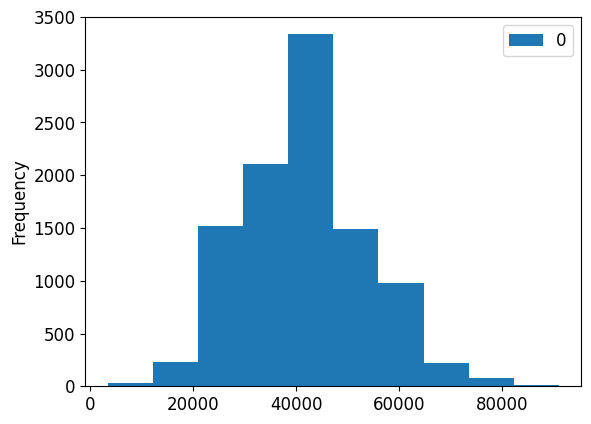

In [376]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

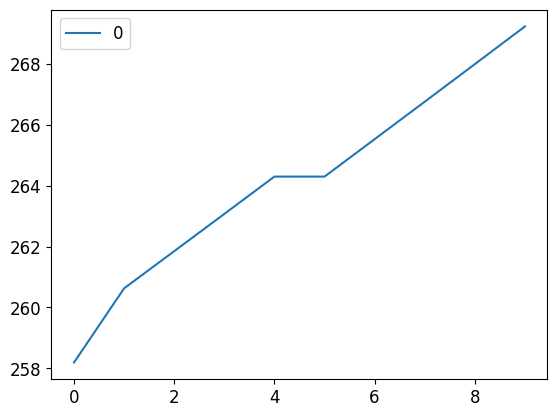

In [377]:
t = []
ev = list(tr_df['H'][180:190])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [378]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][150:180]).fit()
forecast_ses = model_ses.forecast(10)

ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[189] - ses_pd['CVis'].loc[180])/(M[-1] - M[0])

0.9978514426842477

In [379]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][150:180])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))
lr_pred[-1]/M[-1]

1.0113757092387017

In [380]:
t = []
ev = list(tr_df['H'][180:210])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

uv = UVHP()
uv.fit(t)
print(uv.get_params())
mu, alpha, beta = uv.get_params()

model = hk.simulator()

para = {'mu':mu, 'alpha':alpha, 'beta':beta}
itv = [0,10]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
#model.plot_N()
#model.plot_l()

tr_dfp = tr_df[210:220]

Ts = []
for i in range(10000):
  T = model.simulate(itv)
  #print(2000*len(T))
  Ts.append(3500*len(T))

M = list(tr_dfp['CVis'])
print(M[-1] - M[0], np.array(Ts).mean())

(0.9968189194208652, 0.008647444963629857, 0.034002344196941175)
29564.0 34990.9


In [381]:
np.array(Ts).mean()/(M[-1] - M[0])

1.1835644703017183

In [382]:
preds = pd.DataFrame()
preds['p'] = np.array(Ts)
print(len(preds.query('26600 < p < 32400'))/10000)

0.2411


<Axes: ylabel='Frequency'>

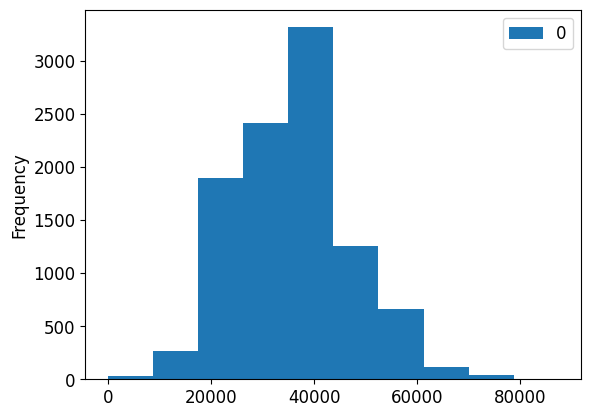

In [383]:
pd.DataFrame(Ts).plot(kind='hist')

<Axes: >

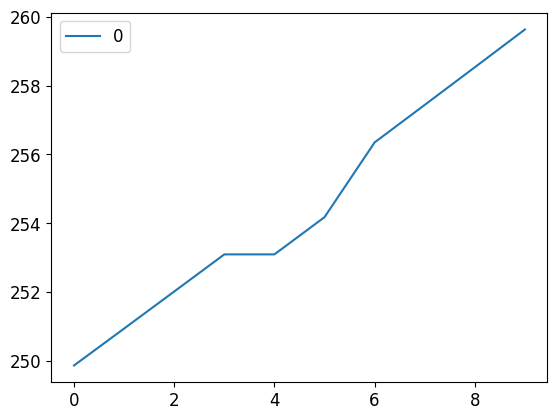

In [384]:
t = []
ev = list(tr_df['H'][210:220])
c = ev[0]
co = 1.
for i in range(1, len(ev)):
  if ev[i] == c:
    co += 1.
    c = ev[i]
  else:
    t += [co]*(ev[i]-c)
    c = ev[i]
    co += 1.

t = np.array(t, dtype=np.float64)

C = [compensator(i, alpha, beta, mu, list(tr_dfp['H'])) for i in list(tr_dfp['H'])]
pd.DataFrame(C).plot(kind='line')

In [385]:
model_ses = SimpleExpSmoothing(tr_df['Visits'][180:210]).fit()
forecast_ses = model_ses.forecast(10)

ses_pd = pd.DataFrame()
ses_pd['CVis'] = np.cumsum(forecast_ses)
(ses_pd['CVis'].loc[219] - ses_pd['CVis'].loc[210])/(M[-1] - M[0])

1.1555948845362545

In [386]:
lr = LinearRegression().fit(np.array(range(30)).reshape(-1, 1), tr_df['CVis'][180:210])
lr_pred = list(lr.predict(np.array(range(30, 40)).reshape(-1,1)))
lr_pred[-1]/M[-1]

1.0009452290047087

In [387]:
tr_dfp

,Date,Visits,CVis,P,H
210,7/29/2020,3903.0,880700.0,251.628571,251
211,7/30/2020,3397.0,884097.0,252.599143,252
212,7/31/2020,3005.0,887102.0,253.457714,253
213,08-01-2020,2305.0,889407.0,254.116286,254
214,08-02-2020,2696.0,892103.0,254.886571,254
215,08-03-2020,3866.0,895969.0,255.991143,255
216,08-04-2020,3826.0,899795.0,257.084286,257
217,08-05-2020,3673.0,903468.0,258.133714,258
218,08-06-2020,3660.0,907128.0,259.179429,259
219,08-07-2020,3136.0,910264.0,260.075429,260
